### Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [90]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# special matplotlib argument for improved plots
from matplotlib import rcParams
import datetime
from datetime import timedelta
import json

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [199]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [10]:
# create dataframe from json file
with open('ultimate_data_challenge.json') as file:
    dat = json.load(file)
df_rider = pd.DataFrame(dat)

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Let's first check how our dataframe looks like.

In [11]:
# check the first few rows
df_rider.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
# check the last few rows
df_rider.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


Let's check how many rows and columns the dataframe has.

In [13]:
# check shape of the dataframe
df_rider.shape

(50000, 12)

It would be good to know the data types and how many entries there are for each column, to see if there are any missing values.

In [14]:
# check info of dataframe
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


From all 12 columns only 'avg_rating_of_driver', 'phone' and 'avg_rating_by_driver' columns have some missing values.

We can also check summary statistics for numeric columns, like minimum and maximum values.

In [15]:
# get stats for float and integer columns
df_rider.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


By looking at the maximums, it seems that 125 trips is the highest number of trips in the first 30 days after signing up. This is around 4 trips per day, which is a reasonable number. There are also riders who didn't take any trips in this timespan. And 5 is high value for an average rating of a driver, it means that this driver only gets the best ratings. Making 160.96 miles (260km) on average per trip is a lot, this driver is spending a lot of time on the road. 

Let's check what the last date in the dataframe is.

In [16]:
# sort values, since they are not in order
df_rider = df_rider.sort_values(by='last_trip_date', ascending=False)

In [20]:
# check if it's sorted correctly
df_rider.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
4486,Winterfell,4,2014-01-25,5.0,1.00,2014-07-01,Android,0.0,True,25.0,11.94,5.0
43047,King's Landing,1,2014-01-15,5.0,1.01,2014-07-01,iPhone,0.8,True,89.3,5.49,4.7
24059,Astapor,1,2014-01-24,4.3,1.11,2014-07-01,iPhone,14.3,False,71.4,8.62,4.9
40290,King's Landing,2,2014-01-07,4.9,1.02,2014-07-01,iPhone,1.6,True,95.2,7.51,4.8
28689,King's Landing,5,2014-01-16,5.0,1.00,2014-07-01,iPhone,0.0,False,75.0,16.32,5.0
41544,Winterfell,7,2014-01-22,5.0,1.11,2014-07-01,iPhone,12.7,True,52.1,3.16,4.8
44457,Winterfell,9,2014-01-13,4.8,1.00,2014-07-01,iPhone,0.0,False,91.7,2.34,4.7
21699,Winterfell,4,2014-01-13,3.4,1.00,2014-07-01,iPhone,0.0,True,66.7,4.35,4.7
15631,King's Landing,0,2014-01-15,4.5,1.15,2014-07-01,iPhone,27.8,False,91.7,3.29,4.9
33653,Winterfell,1,2014-01-07,4.3,1.00,2014-07-01,iPhone,0.0,True,50.0,7.55,5.0


In [33]:
# check if it's sorted correctly
df_rider.tail(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
11557,Winterfell,1,2014-01-01,NaN,1.00,2014-01-01,iPhone,0.0,False,100.0,15.14,5.0
40336,Winterfell,1,2014-01-01,5.0,1.00,2014-01-01,iPhone,0.0,False,100.0,5.98,5.0
11794,Astapor,1,2014-01-01,1.0,1.00,2014-01-01,Android,0.0,False,100.0,1.45,5.0
33172,Winterfell,1,2014-01-01,4.0,1.00,2014-01-01,Android,0.0,False,100.0,1.55,4.0
33241,Winterfell,1,2014-01-01,4.0,1.00,2014-01-01,iPhone,0.0,False,100.0,6.83,3.0
23907,Winterfell,1,2014-01-01,5.0,3.00,2014-01-01,Android,100.0,False,100.0,3.36,5.0
47804,Astapor,1,2014-01-01,NaN,1.00,2014-01-01,Android,0.0,True,100.0,7.17,5.0
11578,Winterfell,1,2014-01-01,NaN,1.00,2014-01-01,Android,0.0,True,100.0,18.63,5.0
11573,Astapor,1,2014-01-01,NaN,1.25,2014-01-01,iPhone,100.0,False,100.0,2.47,5.0
15359,Winterfell,1,2014-01-01,4.0,1.00,2014-01-01,iPhone,0.0,False,100.0,6.16,5.0


2014-07-01 was the last day an entry was made for 'last_trip_date' in the dataframe. Therefore we need to subtract 30 day from this date. In order to be able to do that we need to convert 'last_trip_date' column (and 'signup_date' column as well) from a string format to a date format.
If we look at the 'signup_date' and 'last_trip_date' the data covers about a 6 month timespan.

In [32]:
# change data type
df_rider['signup_date'] = pd.to_datetime(df_rider['signup_date'])
df_rider['last_trip_date'] = pd.to_datetime(df_rider['last_trip_date'])

In [41]:
# check if conversion was made 
df_rider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 4486 to 15359
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


The next step is to subtract 30 days from the 'last_trip_date' in the dataframe 

In [45]:
# substract 30 days from last date in the dataframe
day = df_rider['last_trip_date'].iloc[0] -  pd.to_timedelta(30, unit='d')
day

Timestamp('2014-06-01 00:00:00')

We have to look for all dates that are after 2014-06-01, to get information on users who were retained.

In [87]:
# create a new column called 'last_30_day' where the value is yes 
# if 'last_trip_date' is greater than the 'day' and no if not
df_rider['last_30_day'] = np.where(df_rider['last_trip_date']>=day, 'yes', 'no')

In [47]:
df_rider.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_30_day
4486,Winterfell,4,2014-01-25,5.0,1.00,2014-07-01,Android,0.0,True,25.0,11.94,5.0,yes
43047,King's Landing,1,2014-01-15,5.0,1.01,2014-07-01,iPhone,0.8,True,89.3,5.49,4.7,yes
24059,Astapor,1,2014-01-24,4.3,1.11,2014-07-01,iPhone,14.3,False,71.4,8.62,4.9,yes
40290,King's Landing,2,2014-01-07,4.9,1.02,2014-07-01,iPhone,1.6,True,95.2,7.51,4.8,yes
28689,King's Landing,5,2014-01-16,5.0,1.00,2014-07-01,iPhone,0.0,False,75.0,16.32,5.0,yes


Let's get familiar with our newly created column, to see how it looks like.

In [50]:
# get info about the column
df_rider['last_30_day'].describe()

count     50000
unique        2
top          no
freq      31196
Name: last_30_day, dtype: object

Having 50000 values is a good start, it means there are no missing values in this column. There are two different values, yes or no, which is correct. And there are more no-es that yes-es, which means there are more users that did not make a trip in the last 30 days than users who did.
Let's see how many of each users there are exactly.

In [57]:
# count values in a column
df_rider['last_30_day'].value_counts()

no     31196
yes    18804
Name: last_30_day, dtype: int64

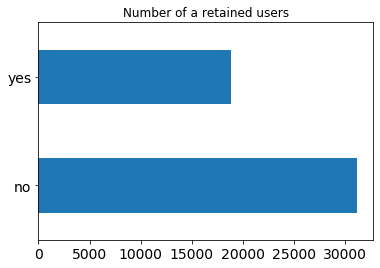

In [62]:
# plot number of 
df_rider['last_30_day'].value_counts().plot.barh(title='Number of a retained users', fontsize=14)

In [357]:
# compute percentige
tot = len(df_rider['last_30_day'])
n = 31196
y = 18804

n_per = (n*100)/tot
y_per = (y*100)/tot
print('Fraction of the observed users that were retained:', y_per, '%.')

Fraction of the observed users that were retained: 37.608 %.


Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

Approach:
- Create a column 'six_month_active': subtract signup_date from last_trip_date, and check if a user is active in their 6th month since signing up or not
- Column 'six_month_active' can have two values: 1-if user is active in their 6th month, 0-if not.
- Use correlation matrix to check if there are any relationships between variables, to figure out what might affect activeness in the 6th month.
- Use these as features in the model. Since the goal is to determine class (active or not) we can use Random Forest, Logistic regression, LinearSVC.

In [390]:
# create a column which states if the user was active in the 6th month
df_rider['diff_last_trip_signup'] = (pd.to_datetime(df_rider['last_trip_date'])-pd.to_datetime(df_rider['signup_date']))/np.timedelta64(1, 'M')
df_rider['active_6th_month'] = np.where(df_rider['diff_last_trip_signup']>5, 1, 0)

In [526]:
df_rider.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_30_day,diff_last_trip_signup,active_6th_month
4486,Winterfell,4,2014-01-25,5.0,1.00,2014-07-01,Android,0.0,True,25.0,11.94,5.0,yes,5.158217,1
43047,King's Landing,1,2014-01-15,5.0,1.01,2014-07-01,iPhone,0.8,True,89.3,5.49,4.7,yes,5.486766,1
24059,Astapor,1,2014-01-24,4.3,1.11,2014-07-01,iPhone,14.3,False,71.4,8.62,4.9,yes,5.191072,1
40290,King's Landing,2,2014-01-07,4.9,1.02,2014-07-01,iPhone,1.6,True,95.2,7.51,4.8,yes,5.749605,1
28689,King's Landing,5,2014-01-16,5.0,1.00,2014-07-01,iPhone,0.0,False,75.0,16.32,5.0,yes,5.453911,1


Since models can deal only with numbers, we can convert categories in some columns into integers. Like yes/no to 1/0.

In [527]:
# make a copy of the dataframe
df_rider_copy = df_rider.copy()

In [528]:
# change values from yes to 1 and no to 0
df_rider_copy = df_rider_copy.replace({'last_30_day': {'yes': 1, 'no': 0}})

In [529]:
# change values from True to 1 and False to 0
df_rider_copy['ultimate_black_user'] *= 1

In [530]:
# check what types of values are in 'phone' column
df_rider_copy.phone.unique()

array(['Android', 'iPhone', None], dtype=object)

In [531]:
df_rider_copy.phone.describe()

count      49604
unique         2
top       iPhone
freq       34582
Name: phone, dtype: object

In [532]:
# count values in 'phone' column
df_rider_copy.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Seems like iPhone is the most popular mobile type.

Let's convert iPhone value to 1 and Android to 0.

In [533]:
# change values from iPhone to 1 and Android to 0
df_rider_copy = df_rider_copy.replace({'phone': {'iPhone': 1, 'Android': 0}})

In [534]:
# check if the conversion was done correctly
df_rider_copy.phone.value_counts()

1.0    34582
0.0    15022
Name: phone, dtype: int64

In [535]:
# see what values are in the 'city' column
df_rider_copy.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

We can convert categorical variable 'city' into dummy variables, one for each city.

In [536]:
# create dummy variables
df_with_dummies = pd.get_dummies(df_rider_copy, prefix='category', columns=['city'])

In [537]:
df_with_dummies.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_30_day,diff_last_trip_signup,active_6th_month,category_Astapor,category_King's Landing,category_Winterfell
4486,4,2014-01-25,5.0,1.00,2014-07-01,0.0,0.0,1,25.0,11.94,5.0,1,5.158217,1,0,0,1
43047,1,2014-01-15,5.0,1.01,2014-07-01,1.0,0.8,1,89.3,5.49,4.7,1,5.486766,1,0,1,0
24059,1,2014-01-24,4.3,1.11,2014-07-01,1.0,14.3,0,71.4,8.62,4.9,1,5.191072,1,1,0,0
40290,2,2014-01-07,4.9,1.02,2014-07-01,1.0,1.6,1,95.2,7.51,4.8,1,5.749605,1,0,1,0
28689,5,2014-01-16,5.0,1.00,2014-07-01,1.0,0.0,0,75.0,16.32,5.0,1,5.453911,1,0,1,0


Let's rename King's Landing so it won't cause any problems:

In [538]:
df_with_dummies = df_with_dummies.rename(columns={"category_King's Landing": "category_Kings_Landing"})

In [539]:
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 4486 to 15359
Data columns (total 17 columns):
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null float64
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
last_30_day               50000 non-null int64
diff_last_trip_signup     50000 non-null float64
active_6th_month          50000 non-null int64
category_Astapor          50000 non-null uint8
category_Kings_Landing    50000 non-null uint8
category_Winterfell       50000 non-null uint8
dtypes: datetime64[ns](2), float64(8), int64(4), uint8(

For now, we are done with conversions. Let's move to the next step, where we check if we can find any correlation between variables.

But first we let's get a basic summary statistics for each of the columns.

In [407]:
df_with_dummies.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_30_day,member_duration,days_last_trip,diff_last_trip_signup,active_6th_month,category_Astapor,category_King's Landing,category_Winterfell
count,50000.000000,41878.000000,50000.000000,49604.000000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,0.697162,8.849536,0.37708,60.926084,5.796827,4.778158,0.376080,92.790100,72.665220,3.048608,0.223880,0.330680,0.202600,0.466720
std,3.792684,0.617338,0.222336,0.459491,19.958811,0.48466,37.081503,5.707357,0.446652,0.484405,62.129822,61.718985,2.041268,0.416847,0.470463,0.401941,0.498896
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000,27.000000,13.000000,0.887082,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.900000,1.000000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000,110.000000,54.000000,3.614037,0.000000,0.000000,0.000000,0.000000
75%,3.000000,5.000000,1.050000,1.000000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000,150.000000,137.000000,4.928233,0.000000,1.000000,0.000000,1.000000
max,125.000000,5.000000,8.000000,1.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000,181.000000,181.000000,5.946734,1.000000,1.000000,1.000000,1.000000


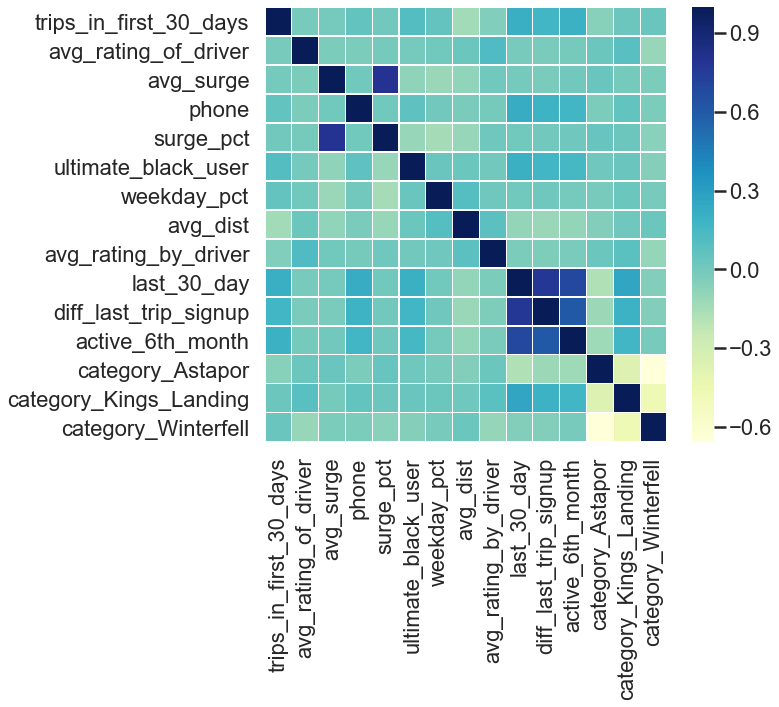

In [540]:
# correlation Matrix for all variables
corrmat_dum = df_with_dummies.corr()   
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat_dum, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

From the correlation matrix we notice that there are a few strong correlations. Last_30_day (active users) and diff_last_trip_signup are strongly correlated with users active in the 6th month, which makes sense because all are calculated from last_trip_date or/and signup_date. For this reason we won't include these variables in models. Another correlation is between avg_surge and surge_pct, but we are not interested in this one.

In [541]:
# correlation of valiables with 'active' user
corrmat_dum['active_6th_month'].sort_values(ascending=False)

active_6th_month          1.000000
last_30_day               0.691779
diff_last_trip_signup     0.610992
trips_in_first_30_days    0.200563
phone                     0.170201
category_Kings_Landing    0.166057
ultimate_black_user       0.154334
surge_pct                 0.018170
avg_surge                 0.007247
weekday_pct               0.001407
avg_rating_of_driver     -0.007815
category_Winterfell      -0.015240
avg_rating_by_driver     -0.021244
avg_dist                 -0.089616
category_Astapor         -0.125710
Name: active_6th_month, dtype: float64

If we exclude variables mentioned above, it seems that trips_in_first_30_days might be the most important feature that affects activeness of a user in their 6th month.

In [413]:
# get information about the dataframe
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 4486 to 15359
Data columns (total 19 columns):
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null float64
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
last_30_day               50000 non-null int64
member_duration           50000 non-null int64
days_last_trip            50000 non-null int64
diff_last_trip_signup     50000 non-null float64
active_6th_month          50000 non-null int64
category_Astapor          50000 non-null uint8
category_Kings_Landing    50000 non-null uint8
category

### Instead of filling out the empty rows with average values of a specific column, we are going to eliminate all empty rows, to get results from real entries and not based on generic values.

In [414]:
# drop all rows that are empty
df_with_dummies_non_null = df_with_dummies.dropna(subset=['avg_rating_of_driver', 'phone', 'avg_rating_by_driver'])

In [415]:
df_with_dummies_non_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 4486 to 15359
Data columns (total 19 columns):
trips_in_first_30_days    41445 non-null int64
signup_date               41445 non-null datetime64[ns]
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null float64
surge_pct                 41445 non-null float64
ultimate_black_user       41445 non-null int64
weekday_pct               41445 non-null float64
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
last_30_day               41445 non-null int64
member_duration           41445 non-null int64
days_last_trip            41445 non-null int64
diff_last_trip_signup     41445 non-null float64
active_6th_month          41445 non-null int64
category_Astapor          41445 non-null uint8
category_Kings_Landing    41445 non-null uint8
category

In [416]:
# change float type into integer
df_with_dummies_non_null.phone = df_with_dummies_non_null.phone.astype(int)

/anaconda3/envs/statenv/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


First, we will create a simple model with just one independent variable 'trips_in_first_30_days' and our dependent variable 'active_6th_month'.

In [417]:
df_with_dummies_non_null_1 = df_with_dummies_non_null[['active_6th_month', 'trips_in_first_30_days']]

In [418]:
# labels are the values we want to predict
labels_1 = np.array(df_with_dummies_non_null_1['active_6th_month']) 

# remove the labels from the features
# axis 1 refers to the columns
features_1 = df_with_dummies_non_null_1[['trips_in_first_30_days']]

# saving feature names for later use
feature_list_1 = list(features_1.columns) 

# convert to numpy array
features_1 = np.array(features_1)

In [ ]:
We will do a cross validation on selected classifiers to see which perform the best. 

In [419]:
# cros validate selected classifiers
np.random.seed(42)
models = [
    RandomForestClassifier(),
    LinearSVC(),
    LogisticRegression(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    auc_Xt = cross_val_score(model, features_1, labels_1, scoring='roc_auc', cv=CV)
    for fold_idx, auc in enumerate(auc_Xt):
        entries.append((model_name, fold_idx, auc))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'roc_auc'])

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/statenv/lib/python3.6/si

In [420]:
# print the scoring dataframe with results
cv_df

,model_name,fold_idx,roc_auc
0,RandomForestClassifier,0,0.604725
1,RandomForestClassifier,1,0.595984
2,RandomForestClassifier,2,0.560889
3,RandomForestClassifier,3,0.581239
4,RandomForestClassifier,4,0.487582
5,LinearSVC,0,0.615219
6,LinearSVC,1,0.654760
7,LinearSVC,2,0.687810
8,LinearSVC,3,0.546509
9,LinearSVC,4,0.487726


It is interesting to see that LineraSVC and Logistic Refression performed the same.

Let's try it with a train/test split method.

In [421]:
# split dataset into training set and test set, 70% training and 30% test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features_1, labels_1, test_size=0.3, random_state=42)

In [422]:
# instantiate model 
rand_forest_1 = RandomForestClassifier()

# train the model on training data
rand_forest_1.fit(X_train_1, y_train_1)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [423]:
# use the forest's predict method on the test data
rf_pred_1 = rand_forest_1.predict(X_test_1)

In [424]:
# calculate ROC AUC from prediction scores
print('ROC AUC score: ', metrics.roc_auc_score(y_test_1, rf_pred_1))

ROC AUC score:  0.5214940440891814


In [425]:
# calculate F1 score from prediction scores
print('f1_score: ', metrics.f1_score(y_test_1, rf_pred_1))

f1_score:  0.11483253588516747


In [426]:
# print confusion matrix
print(metrics.confusion_matrix(y_test_1, rf_pred_1))

[[9085  203]
 [2942  204]]


In [211]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [429]:
def cv_score(clf, x, y, score_func=roc_auc_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(y[test], clf.predict(x[test])) # evaluate score function on held-out data
    return result / nfold # average

In [430]:
score_rd1 = cv_score(rand_forest_1, X_train_1, y_train_1)
print(score_rd1)

0.5268021688766206


In [431]:
clf_log1 = LogisticRegression(solver='lbfgs')
score_log1 = cv_score(clf_log1, X_train_1, y_train_1)
print(score_log1)

0.5223319283024066


In [433]:
clf_lin1 = LinearSVC(max_iter=1000)
score_lin1 = cv_score(clf_lin1, X_train_1, y_train_1)
print(score_lin1)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5228344147321589


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In this first round, while using only 'trips_in_first_30_days' as independent variable, LinearSVC performed slightly better than the Logistic Regression classifier or Random ForestClassifier.

Let's include more features:

In [434]:
df_with_dummies_non_null_2 = df_with_dummies_non_null[['active_6th_month', 'trips_in_first_30_days', 'phone', 'ultimate_black_user']]

In [435]:
# labels are the values we want to predict
labels_2 = np.array(df_with_dummies_non_null_2['active_6th_month']) 

# remove the labels from the features
# axis 1 refers to the columns
features_2 = df_with_dummies_non_null_2.drop('active_6th_month', axis=1)

# saving feature names for later use
feature_list_2 = list(features_2.columns) 

# convert to numpy array
features_2 = np.array(features_2)

In [436]:
# split dataset into training set and test set, 70% training and 30% test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_2, labels_2, test_size=0.3, random_state=42)

In [437]:
# instantiate model 
rand_forest_2 = RandomForestClassifier()

# train the model on training data
rand_forest_2.fit(X_train_2, y_train_2)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [438]:
# use the forest's predict method on the test data
rf_pred_2 = rand_forest_2.predict(X_test_2)

In [439]:
# calculate F1 score from prediction scores
print('f1_score: ', metrics.f1_score(y_test_2, rf_pred_2))

f1_score:  0.18763213530655393


In [440]:
# calculate accuracy score
print('accuracy_score: ', metrics.accuracy_score(y_test_2, rf_pred_2))

accuracy_score:  0.7527746501528069


In [497]:
# calculate the roc_auc score
score_rd2 = cv_score(rand_forest_2, X_train_2, y_train_2)
print('roc_auc_score:', score_rd2)

roc_auc_score: 0.5455046471854088


In [442]:
# create pandas Searies from feature importance
feature_imp_rf2 = pd.Series(rand_forest_2.feature_importances_, index=feature_list_2).sort_values(ascending=False)
feature_imp_rf2

trips_in_first_30_days    0.508563
phone                     0.287183
ultimate_black_user       0.204254
dtype: float64

In [443]:
# use Logistic Regression classifier and calculate the roc_auc score
clf_log2 = LogisticRegression(solver='lbfgs')
score_log2 = cv_score(clf_log2, X_train_2, y_train_2)
print(score_log2)

0.533524665016652


In [444]:
# create pandas Searies from feature importance
feature_imp_log2 = pd.Series(clf_log2.coef_[0], index=feature_list_2).sort_values(ascending=False)
feature_imp_log2

phone                     0.967429
ultimate_black_user       0.624522
trips_in_first_30_days    0.090159
dtype: float64

In [447]:
# use LinerSVC classifier and calculate the roc_auc score
clf_lin2 = LinearSVC(max_iter=1000)
score_lin2 = cv_score(clf_lin2, X_train_2, y_train_2)
print(score_lin2)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5313553493862401


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [448]:
# create pandas Searies from feature importance
feature_imp_lin2 = pd.Series(clf_lin2.coef_[0], index=feature_list_2).sort_values(ascending=False)
feature_imp_lin2

phone                     0.292985
ultimate_black_user       0.227407
trips_in_first_30_days    0.041264
dtype: float64

This time the Random Forest classifier performed slightly better, which also has a different order of feature importance compared to the other two.

Let's add three cities and build another model, to see how they affect the dependent variable.

In [449]:
# create a dataframe with selected columns
df_with_dummies_non_null_3 = df_with_dummies_non_null[['active_6th_month', 'trips_in_first_30_days', 'phone', 'ultimate_black_user', 'category_Astapor', 'category_Kings_Landing', 'category_Winterfell']]

In [450]:
# labels are the values we want to predict
labels_3 = np.array(df_with_dummies_non_null_3['active_6th_month']) 

# remove the labels from the features
# axis 1 refers to the columns
features_3 = df_with_dummies_non_null_3.drop('active_6th_month', axis=1)

# saving feature names for later use
feature_list_3 = list(features_3.columns) 

# convert to numpy array
features_3 = np.array(features_3)

In [451]:
# split dataset into training set and test set, 70% training and 30% test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features_3, labels_3, test_size=0.3, random_state=42)

In [452]:
# instantiate model 
rand_forest_3 = RandomForestClassifier()
score_rd3 = cv_score(rand_forest_3, X_train_3, y_train_3)
print(score_rd3)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.550421108508327


In [453]:
# create pandas Searies from feature importance
feature_imp_rf3 = pd.Series(rand_forest_3.feature_importances_, index=feature_list_3).sort_values(ascending=False)
feature_imp_rf3

trips_in_first_30_days    0.457207
phone                     0.182776
ultimate_black_user       0.146240
category_Kings_Landing    0.139360
category_Astapor          0.043695
category_Winterfell       0.030723
dtype: float64

In [454]:
# train the model on training data
rand_forest_3.fit(X_train_3, y_train_3)

# use the forest's predict method on the test data
rf_pred_3 = rand_forest_3.predict(X_test_3)

# calculate F1 score from prediction scores
print('roc_auc_score: ', metrics.roc_auc_score(y_test_3, rf_pred_3))

roc_auc_score:  0.5471332216839617


In [455]:
# instantiate model and compute roc_auc_score from function
clf_log3 = LogisticRegression(solver='lbfgs', max_iter=1000)
score_log3 = cv_score(clf_log3, X_train_3, y_train_3)
print(score_log3)

0.549653493342192


In [456]:
# create pandas Searies from feature importance
feature_imp_log3 = pd.Series(clf_log3.coef_[0], index=feature_list_3).sort_values(ascending=False)
feature_imp_log3

phone                     0.945995
ultimate_black_user       0.638142
category_Kings_Landing    0.571479
trips_in_first_30_days    0.088098
category_Winterfell      -0.050122
category_Astapor         -0.514320
dtype: float64

In [458]:
# instantiate model and compute roc_auc_score from function
clf_lin3 = LinearSVC(max_iter=1000)
score_lin3 = cv_score(clf_lin3, X_train_3, y_train_3)
print(score_lin3)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5413407140370454


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [459]:
# create pandas Searies from feature importance
feature_imp_lin3 = pd.Series(clf_lin3.coef_[0], index=feature_list_3).sort_values(ascending=False)
feature_imp_lin3

phone                     0.280652
ultimate_black_user       0.224083
trips_in_first_30_days    0.041064
category_Kings_Landing   -0.003131
category_Winterfell      -0.253712
category_Astapor         -0.390105
dtype: float64

Yet again Random Forest classifier performed the best, but not by much. It is interesting to see how feature importance varies.

Now we will build a model without the 'trips_in_first_30_days' variable, which seems to be the most important in a Random Forest model.

In [460]:
# create a dataframe with selected columns
df_with_dummies_non_null_4 = df_with_dummies_non_null[['active_6th_month', 'phone', 'ultimate_black_user', 'category_Astapor', 'category_Kings_Landing', 'category_Winterfell']]

In [461]:
# labels are the values we want to predict
labels_4 = np.array(df_with_dummies_non_null_4['active_6th_month']) 

# remove the labels from the features
# axis 1 refers to the columns
features_4 = df_with_dummies_non_null_4.drop('active_6th_month', axis=1)

# saving feature names for later use
feature_list_4 = list(features_4.columns) 

# convert to numpy array
features_4 = np.array(features_4)

In [462]:
# split dataset into training set and test set, 70% training and 30% test
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(features_4, labels_4, test_size=0.3, random_state=42)

In [498]:
# instantiate model 
rand_forest_4 = RandomForestClassifier()
score_rd4 = cv_score(rand_forest_4, X_train_4, y_train_4)
print(score_rd4)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5


In [464]:
# create pandas Searies from feature importance
feature_imp_rf4 = pd.Series(rand_forest_4.feature_importances_, index=feature_list_4).sort_values(ascending=False)
feature_imp_rf4

phone                     0.349957
ultimate_black_user       0.279138
category_Kings_Landing    0.232190
category_Astapor          0.107673
category_Winterfell       0.031042
dtype: float64

In [465]:
# instantiate model and compute roc_auc_score from function
clf_log4 = LogisticRegression(solver='lbfgs')
score_log4 = cv_score(clf_log4, X_train_4, y_train_4)
print(score_log4)

0.5441182030283971


In [466]:
# create pandas Searies from feature importance
feature_imp_log4 = pd.Series(clf_log4.coef_[0], index=feature_list_4).sort_values(ascending=False)
feature_imp_log4

phone                     0.966712
ultimate_black_user       0.720362
category_Kings_Landing    0.566371
category_Winterfell      -0.025098
category_Astapor         -0.540348
dtype: float64

In [467]:
# instantiate model and compute roc_auc_score from function
clf_lin4 = LinearSVC()
score_lin4 = cv_score(clf_lin4, X_train_4, y_train_4)
print(score_lin4)

0.5


In [468]:
# create pandas Searies from feature importance
feature_imp_lin4 = pd.Series(clf_lin4.coef_[0], index=feature_list_4).sort_values(ascending=False)
feature_imp_lin4

phone                     0.293721
ultimate_black_user       0.259598
category_Kings_Landing    0.019606
category_Winterfell      -0.223190
category_Astapor         -0.382332
dtype: float64

This round the Logistic Regression classifier performed the best. Without the 'trips_in_first_30_days' variable, feature importance is similar for all three classifiers. Noticing that 'phone' variable is also very important.

Now, let's build a model with only the three cities, to see if King's Landing is the most important from them, based on previous models.

In [469]:
# create a dataframe with selected columns
df_with_dummies_non_null_5 = df_with_dummies_non_null[['active_6th_month', 'category_Astapor', 'category_Kings_Landing', 'category_Winterfell']]

In [470]:
# labels are the values we want to predict
labels_5 = np.array(df_with_dummies_non_null_5['active_6th_month']) 

# remove the labels from the features
# axis 1 refers to the columns
features_5 = df_with_dummies_non_null_5.drop('active_6th_month', axis=1)

# saving feature names for later use
feature_list_5 = list(features_5.columns) 

# convert to numpy array
features_5 = np.array(features_5)

In [471]:
# split dataset into training set and test set, 70% training and 30% test
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(features_5, labels_5, test_size=0.3, random_state=42)

In [499]:
# instantiate model 
rand_forest_5 = RandomForestClassifier()
score_rd5 = cv_score(rand_forest_5, X_train_5, y_train_5)
print(score_rd5)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5


In [500]:
# create pandas Searies from feature importance
feature_imp_rf5 = pd.Series(rand_forest_5.feature_importances_, index=feature_list_5).sort_values(ascending=False)
feature_imp_rf5

category_Kings_Landing    0.672432
category_Astapor          0.240663
category_Winterfell       0.086904
dtype: float64

In [501]:
# instantiate model and compute roc_auc_score from function
clf_log5 = LogisticRegression(solver='lbfgs')
score_log5 = cv_score(clf_log5, X_train_5, y_train_5)
print(score_log5)

0.5


In [502]:
# create pandas Searies from feature importance
feature_imp_log5 = pd.Series(clf_log5.coef_[0], index=feature_list_5).sort_values(ascending=False)
feature_imp_log5

category_Kings_Landing    0.594317
category_Winterfell      -0.063707
category_Astapor         -0.524962
dtype: float64

In [503]:
# instantiate model and compute roc_auc_score from function
clf_lin5 = LinearSVC()
score_lin5 = cv_score(clf_lin5, X_train_5, y_train_5)
print(score_lin5)

0.5


In [504]:
# create pandas Searies from feature importance
feature_imp_lin5 = pd.Series(clf_lin5.coef_[0], index=feature_list_5).sort_values(ascending=False)
feature_imp_lin5

category_Kings_Landing    0.118105
category_Winterfell      -0.161212
category_Astapor         -0.310485
dtype: float64

This was a bit unexpected, to get the same score for all three. It seems that King's Landing is the most important city that affects our dependent variable.

Let's build a model with average distance, average ratings of driver and by driver, to see how these variables affect the dependent variable.

In [505]:
# create a dataframe with selected columns
df_with_dummies_non_null_6 = df_with_dummies_non_null[['active_6th_month', 'avg_rating_of_driver', 'avg_dist', 'avg_rating_by_driver']]

In [506]:
# labels are the values we want to predict
labels_6 = np.array(df_with_dummies_non_null_6['active_6th_month']) 

# remove the labels from the features
# axis 1 refers to the columns
features_6 = df_with_dummies_non_null_6.drop('active_6th_month', axis=1)

# saving feature names for later use
feature_list_6 = list(features_6.columns) 

# convert to numpy array
features_6 = np.array(features_6)

In [507]:
# split dataset into training set and test set, 70% training and 30% test
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(features_6, labels_6, test_size=0.3, random_state=42)

In [508]:
# instantiate model and compute the roc_auc score
rand_forest_6 = RandomForestClassifier()
score_rd6 = cv_score(rand_forest_6, X_train_6, y_train_6)
print(score_rd6)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5816942651831147


In [509]:
# create pandas Searies from feature importance
feature_imp_rf6 = pd.Series(rand_forest_6.feature_importances_, index=feature_list_6).sort_values(ascending=False)
feature_imp_rf6

avg_dist                0.740982
avg_rating_by_driver    0.137944
avg_rating_of_driver    0.121074
dtype: float64

In [510]:
# instantiate model and compute roc_auc_score from function
clf_log6 = LogisticRegression(solver='lbfgs')
score_log6 = cv_score(clf_log6, X_train_6, y_train_6)
print(score_log6)

0.5


In [511]:
# create pandas Searies from feature importance
feature_imp_log6 = pd.Series(clf_log6.coef_[0], index=feature_list_6).sort_values(ascending=False)
feature_imp_log6

avg_rating_of_driver   -0.025648
avg_rating_by_driver   -0.046674
avg_dist               -0.048653
dtype: float64

In [512]:
# instantiate model and compute roc_auc_score from function
clf_lin6 = LinearSVC()
score_lin6 = cv_score(clf_lin6, X_train_6, y_train_6)
print(score_lin6)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [513]:
# create pandas Searies from feature importance
feature_imp_lin6 = pd.Series(clf_lin6.coef_[0], index=feature_list_6).sort_values(ascending=False)
feature_imp_lin6

avg_rating_of_driver   -0.008382
avg_dist               -0.016635
avg_rating_by_driver   -0.018208
dtype: float64

Random Forest performed the best. This time each one has a different feature importance. 

As the last one, we include all variables to see if we can get a better roc_auc score.

In [549]:
# create a dataframe with selected columns
df_with_dummies_non_null_7 = df_with_dummies_non_null[['active_6th_month', 'trips_in_first_30_days', 'phone', 'ultimate_black_user', 'category_Astapor', 'category_Kings_Landing', 'category_Winterfell', 'avg_rating_of_driver', 'avg_dist', 'avg_rating_by_driver', 'weekday_pct', 'avg_surge']]

In [550]:
# labels are the values we want to predict
labels_7 = np.array(df_with_dummies_non_null_7['active_6th_month']) 

# remove the labels from the features
# axis 1 refers to the columns
features_7 = df_with_dummies_non_null_7.drop('active_6th_month', axis=1)

# saving feature names for later use
feature_list_7 = list(features_7.columns) 

# convert to numpy array
features_7 = np.array(features_7)

In [551]:
# split dataset into training set and test set, 70% training and 30% test
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(features_7, labels_7, test_size=0.3, random_state=42)

In [552]:
# instantiate model and compute the roc_auc score
rand_forest_7 = RandomForestClassifier()
score_rd7 = cv_score(rand_forest_7, X_train_7, y_train_7)
print(score_rd7)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6129880774493855


In [553]:
# create pandas Searies from feature importance
feature_imp_rf7 = pd.Series(rand_forest_7.feature_importances_, index=feature_list_7).sort_values(ascending=False)
feature_imp_rf7

avg_dist                  0.290377
weekday_pct               0.176099
avg_surge                 0.125777
avg_rating_by_driver      0.109680
avg_rating_of_driver      0.102251
trips_in_first_30_days    0.101622
phone                     0.024981
ultimate_black_user       0.024804
category_Kings_Landing    0.020737
category_Astapor          0.012208
category_Winterfell       0.011464
dtype: float64

In [554]:
# instantiate model and compute roc_auc_score from function
clf_log7 = LogisticRegression(solver='lbfgs')
score_log7 = cv_score(clf_log7, X_train_7, y_train_7)
print(score_log7)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.553749718521199


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [555]:
# create pandas Searies from feature importance
feature_imp_log7 = pd.Series(clf_log7.coef_[0], index=feature_list_7).sort_values(ascending=False)
feature_imp_log7

phone                     0.953391
ultimate_black_user       0.601259
category_Kings_Landing    0.458787
trips_in_first_30_days    0.080064
weekday_pct              -0.001190
avg_dist                 -0.044656
avg_rating_of_driver     -0.091095
avg_rating_by_driver     -0.156171
avg_surge                -0.170644
category_Winterfell      -0.219679
category_Astapor         -0.706175
dtype: float64

In [556]:
# instantiate model and compute roc_auc_score from function
clf_lin7 = LinearSVC()
score_lin7 = cv_score(clf_lin7, X_train_7, y_train_7)
print(score_lin7)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5282403094020756


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [557]:
# create pandas Searies from feature importance
feature_imp_lin7 = pd.Series(clf_lin7.coef_[0], index=feature_list_7).sort_values(ascending=False)
feature_imp_lin7

phone                     0.286413
ultimate_black_user       0.209786
avg_surge                 0.085626
trips_in_first_30_days    0.054038
weekday_pct               0.020564
avg_rating_by_driver     -0.003188
avg_rating_of_driver     -0.018243
category_Kings_Landing   -0.018909
avg_dist                 -0.023055
category_Winterfell      -0.266074
category_Astapor         -0.395372
dtype: float64

Random Forest performed the best. It is a surprise to see that the most important feature is the average distance, so far it looked more like 'trips_in_first_30_days' would have the greatest effect on activeness in the 6th month.

The next step is to build optimized models, for which we need to find the best parameters.

#### PARAMETERS EVALUATION

##### Random Forest

In [335]:
from sklearn.model_selection import RandomizedSearchCV

In [336]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 10)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [558]:
# use the random grid to search for best hyperparameters
# first create the base model to tune
rf_rs = RandomForestClassifier()

# random search of parameters, using 3 fold cross validation, 
# search across 5 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_rs, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1) 

# fit the random search model
rf_random.fit(X_train_7, y_train_7)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   26.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

The best parameters from fitting the random search:

In [559]:
rf_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

To determine if random search yielded a better model, we compare the base model (rand_forest_7) with the best random search model.

In [560]:
# instantiate model 
rf_random_search = RandomForestClassifier(n_estimators = 20, min_samples_split = 10, min_samples_leaf = 2, max_features= 'sqrt', max_depth  = 50, bootstrap = True)

score_rd_rs = cv_score(rf_random_search, X_train_7, y_train_7)
print(score_rd_rs)

0.635062922842959


Indeed, by using random search we get a better ROC_AUC score. Base model has score of 0.613.

In [561]:
# train the model on training data
rf_random_search.fit(X_train_7, y_train_7)

# use the forest's predict method on the test data
rd_pred_T7 = rf_random_search.predict(X_test_7)

In [567]:
# printing the first 5 values of y_test_P and the predict results target
for i in range(0, 8):
    print('Actual: {} and Predicted: {}'.format(list(y_test_7)[i], rd_pred_T7[i]))

Actual: 0 and Predicted: 0
Actual: 0 and Predicted: 0
Actual: 0 and Predicted: 0
Actual: 1 and Predicted: 0
Actual: 1 and Predicted: 1
Actual: 0 and Predicted: 1
Actual: 0 and Predicted: 0
Actual: 0 and Predicted: 0


Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to focus our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [569]:
# create the parameter grid based on the results of random search 
param_grid_t = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60, 80],
    'n_estimators': [30, 50, 60, 100]
}

In [570]:
# create a based model
RF2 = RandomForestClassifier()

# instantiate the grid search model
grid_search = GridSearchCV(estimator = RF2, param_grid = param_grid_t, cv = 3, n_jobs = -1, verbose = 2)

# fit the grid search to the data
grid_search.fit(X_train_7, y_train_7)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   27.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [571]:
# check the best parameters for the model
grid_search.best_params_

{'bootstrap': True, 'max_depth': 50, 'n_estimators': 100}

In [572]:
# check the best estimator for the model
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [573]:
# getting prediction values
grid_predictions = best_grid.predict(X_test_7)

In [575]:
print('ROC_AUC score: ', metrics.roc_auc_score(y_test_7, grid_predictions))

ROC_AUC score:  0.6334990620138611


In [574]:
# printing the first 6 values of y_test_P and the predicted results target
for i in range(0, 6):
    print('Actual value: {} and Predicted value: {}'.format(list(y_test_7)[i], grid_predictions[i]))

Actual value: 0 and Predicted value: 0
Actual value: 0 and Predicted value: 0
Actual value: 0 and Predicted value: 0
Actual value: 1 and Predicted value: 0
Actual value: 1 and Predicted value: 0
Actual value: 0 and Predicted value: 0


##### Logistic Regression

In [577]:
#the grid of parameters to search through
Cs = [0.001, 0.1, 1, 10, 100]
max_score = 0

# for each C in Cs create a logistic regression model
for C_param in Cs:
        clf = LogisticRegression(C=C_param, solver='lbfgs')
        score = cv_score(clf, X_train_7, y_train_7)
        # check if the calculated score is greater than current max_score
        if score > max_score:
            max_score = score
            best_C_param =C_param
print('C parameter:', best_C_param, 'has the highest average score of', max_score)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

C parameter: 10 has the highest average score of 0.5560673670592633


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [578]:
# initiate a model
clf_best_C_param = LogisticRegression(C=best_C_param, solver='lbfgs')

# fit the model on the trainng data
clf_best_C_param.fit(X_train_7, y_train_7)

# print the accuracy from the testing data
print('Accuracy score: ', metrics.accuracy_score(y_test_7, clf_best_C_param.predict(X_test_7)))
print('ROC_AUC score: ', metrics.roc_auc_score(y_test_7, clf_best_C_param.predict(X_test_7)))

Accuracy score:  0.7598520186585169
ROC_AUC score:  0.5644208729568138


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [579]:
from sklearn.model_selection import GridSearchCV

# setup the hyperparameter grid
param_grid = {'C': Cs}

# instantiate a logistic regression classifier
log_reg = LogisticRegression(solver='lbfgs')

# instantiate the GridSearchCV object
log_reg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# fit it to the data
log_reg_cv.fit(X_train_7, y_train_7)

# print the tuned parameter, score
print('Best parameter:',log_reg_cv.best_params_)
print('Best score:',log_reg_cv.best_score_)
print('Estimator which gave highest score:',log_reg_cv.best_estimator_)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

Best parameter: {'C': 100}
Best score: 0.7603667574368344
Estimator which gave highest score: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Next, we check how this model performs on the test set.

In [582]:
# print the accuracy from the testing data
print('Accuracy score: ', metrics.accuracy_score(y_test_7, log_reg_cv.predict(X_test_7)))
print('ROC_AUC score: ', metrics.roc_auc_score(y_test_7, log_reg_cv.predict(X_test_7)))

Accuracy score:  0.7596911693742963
ROC_AUC score:  0.5695681608736578


It has a similar performance than the model without GridSearchCV.

##### LinearSVC

In [583]:
# setup the hyperparameter grid
param_grid = {'C': [0.001, 0.1, 1, 10, 100, 1000]}

# instantiate a LinearSVC classifier
lin_hyper = LinearSVC()

# instantiate the GridSearchCV object
lin_hyper_cv = GridSearchCV(lin_hyper, param_grid, cv=5)

# fit it to the data
lin_hyper_cv.fit(X_train_7, y_train_7)

# print the tuned parameter, score
print('Best parameter:', lin_hyper_cv.best_params_)
print('Best score:', lin_hyper_cv.best_score_)
print('Estimator which gave highest score:', lin_hyper_cv.best_estimator_)

/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/statenv/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best parameter: {'C': 0.001}
Best score: 0.7593326669194443
Estimator which gave highest score: LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [590]:
# print the accuracy from the testing data
print('Accuracy score: ', metrics.accuracy_score(y_test_7, lin_hyper_cv.predict(X_test_7)))
print('ROC_AUC score: ', metrics.roc_auc_score(y_test_7, lin_hyper_cv.predict(X_test_7)))

Accuracy score:  0.7563133344056618
ROC_AUC score:  0.5395610233083806


Since Random Search with RandomForest classifier performed the best, let's check its feature importance:

In [586]:
# create pandas Searies from feature importance
feature_imp_rf_7_rs = pd.Series(rf_random_search.feature_importances_, index=feature_list_7).sort_values(ascending=False)
feature_imp_rf_7_rs

avg_dist                  0.212614
weekday_pct               0.181138
avg_surge                 0.149106
avg_rating_by_driver      0.144428
trips_in_first_30_days    0.093952
avg_rating_of_driver      0.087539
phone                     0.037963
ultimate_black_user       0.033720
category_Kings_Landing    0.030639
category_Astapor          0.018285
category_Winterfell       0.010617
dtype: float64

The order of features is the same, only avg_rating_of_driver and trips_in_first_30_days are switched.

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system.
Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

We have built several classification models to predict whether the user will be retained or not. Out of everything we tried the Random Forest classifier performed the best, with an ROC_AUC score of 0.6351. We used Random search and GridSearchCV to evaluate parameters and got slightly higher ROC_AUC scores than without these two methods.
There are many concerns and questions, for example what results would we get if we use some other classifier, perhaps K-Nearest Neighbours or Naïve Bayes. What about different performance metrics, like F1-Score. Another question is what would happen if we fill in empty rows with average values of the column instead of eliminating empty rows? How could we build an even better model? Where did the data come from? How was it collected and processed? Which leads us to model validity. Our model is only as accurate as the input data as well as the degree to which we know how to use it.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

The two key predictors of long term rider retention are average distance traveled and percentage of trips taken on weekdays. To insure higher long term rider retention Ultimate might try to incentivise and encourage longer trips and trips on weekdays soon after a new rider signs up. This behaviour could be incentivised with discounts on weekdays to encourage the usage of Ultimate for daily commutes, or with advertisements to promote and bring longer trips top of mind for the riders. The important thing is to present and solidify the value proposition Ultimate can offer to riders.
